<a href="https://colab.research.google.com/github/cfcastillo/DS-6-Notebooks/blob/main/Project_3_Notebook_cfc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Definition

The purpose of this project is to predict **new song popularity** (target) based on data features (variables) collected for songs that have been on the top 200 Weekly Global charts of Spotify in 2020 and 2021. [Project details](https://docs.google.com/document/d/1v73i9PjBgqlaW6YMCd76MYSc96q2fqNv/edit)

This is a **supervised regression** problem.

**Goals**

* To Minimize the cross-validated root mean squared error (RMSE) around 10.
* To determine the importance of the features in driving the regression result.
* To choose parameters that will avoid over-fitting in the result.

**Methodology**

The project will be done using tree-based regression techniques.

# Data Collection

The dataset includes all songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 and 2021. Below, is a link to the data description.

[Data Description](https://docs.google.com/document/d/14xiF2TXOGvbMbf5sxYQAwtXDlfrdPh_hxmeDHGCMH0E/edit)

## Imports

In [ ]:
# grab the imports needed for the project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

# all
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import sklearn.model_selection as model_selection

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics  

# Visualization
import graphviz
from IPython.display import display
from sklearn import tree


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Installs
!pip3 install dtreeviz
from dtreeviz.trees import dtreeviz

## Functions


## Load Data

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Load Data
data_path = '/drive/My Drive/Cohort_6/Projects/Project 3/Data/Project_3_Spotify.csv'
data = pd.read_csv(data_path)

# Data Cleaning

In [ ]:
# View top 5 records - all columns
data.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
# Any Nulls?
data.isnull().sum().sum()

0

In [ ]:
# Get a copy of the data before massaging the data.
data_clean = data.copy()

## Drop columns

Since the project requirement is to predict **new** song popularity, we will drop columns that would not be available for new songs. Additionally, we will drop columns that are not predictors, such as the row index and song id.

In [ ]:
# Drop indexes
data_clean.drop(['Index', 'Song ID'], inplace=True, axis=1)

# Drop predictors that would not exist for new songs
data_clean.drop(['Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Streams', 'Weeks Charted'], inplace=True, axis=1)

data_clean.tail()

,Song Name,Artist,Artist Followers,Genre,Release Date,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1551,New Rules,Dua Lipa,27167675,"['dance pop', 'pop', 'uk pop']",2017-06-02,79,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,Cheirosa - Ao Vivo,Jorge & Mateus,15019109,"['sertanejo', 'sertanejo universitario']",2019-10-11,66,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,Havana (feat. Young Thug),Camila Cabello,22698747,"['dance pop', 'electropop', 'pop', 'post-teen ...",2018-01-12,81,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,Surtada - Remix Brega Funk,"Dadá Boladão, Tati Zaqui, OIK",208630,"['brega funk', 'funk carioca']",2019-09-25,60,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F
1555,Lover (Remix) [feat. Shawn Mendes],Taylor Swift,42227614,"['pop', 'post-teen pop']",2019-11-13,70,0.448,0.603,-7.176,0.064,0.433,0.0862,205.272,221307,0.422,G


## Fix Data Types

Some columns were imported as object data types but actually contain numeric values. These columns needed to be converted to their numerical equivalent as required by the XG Boost model. This is being done at this point in the process because Nulls have been removed and the conversion only works with non-null data.

They were:

Artist Followers, Danceability, Energy, Loudness, Speechiness, Acousticness, Liveness, Tempo, Duration (ms), Valence

In [ ]:
# Convert strings into numbers. Note: some are blank so using coerce will turn them into 
# NaN which can then be removed later.

# Target data
data_clean['Popularity'] = pd.to_numeric(data_clean['Popularity'], errors='coerce')

# Feature data
data_clean['Artist Followers'] = pd.to_numeric(data_clean['Artist Followers'], errors='coerce')
data_clean['Danceability'] = pd.to_numeric(data_clean['Danceability'], errors='coerce')
data_clean['Energy'] = pd.to_numeric(data_clean['Energy'], errors='coerce')
data_clean['Loudness'] = pd.to_numeric(data_clean['Loudness'], errors='coerce')
data_clean['Speechiness'] = pd.to_numeric(data_clean['Speechiness'], errors='coerce')
data_clean['Acousticness'] = pd.to_numeric(data_clean['Acousticness'], errors='coerce')
data_clean['Liveness'] = pd.to_numeric(data_clean['Liveness'], errors='coerce')
data_clean['Tempo'] = pd.to_numeric(data_clean['Tempo'], errors='coerce')
data_clean['Duration (ms)'] = pd.to_numeric(data_clean['Duration (ms)'], errors='coerce')
data_clean['Valence'] = pd.to_numeric(data_clean['Valence'], errors='coerce')

# Convert date
data_clean['Release Date'] = pd.to_datetime(data_clean['Release Date'], errors='coerce')

In [ ]:
# Conversion produced some nulls for values that could not be converted. Remove these rows
# since all predictors in these rows are null.

# Identify rows with nulls and observe. Noted that there were 11 rows where all predictors were blank or null.
# print(data_clean.isna().sum())
# data_clean[data_clean.isna().any(axis=1)]

# drop the rows that have null data since all predictors are null making them unusable for predictions.
data_clean = data_clean.dropna()
print(data_clean.isna().sum())

Song Name           0
Artist              0
Artist Followers    0
Genre               0
Release Date        0
Popularity          0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Liveness            0
Tempo               0
Duration (ms)       0
Valence             0
Chord               0
dtype: int64


In [ ]:
# Verify final data types
data_clean.dtypes

Song Name                   object
Artist                      object
Artist Followers           float64
Genre                       object
Release Date        datetime64[ns]
Popularity                 float64
Danceability               float64
Energy                     float64
Loudness                   float64
Speechiness                float64
Acousticness               float64
Liveness                   float64
Tempo                      float64
Duration (ms)              float64
Valence                    float64
Chord                       object
dtype: object

## Feature Engineering

In this step, character data and columns containing multiple values will be split and encoded so they can be modeled.

[Techniques](https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114)

[Encoding Notebook](https://colab.research.google.com/drive/10mMFd3bsO7Gy8MbYY56Ukv8lg0-PCBmc)

[Imputation Notebook](https://colab.research.google.com/drive/1pq84SRJTOXSdKN9j9g6pORrKtIuQomhH)

[Lambda Examples](https://colab.research.google.com/drive/1jz5eSsPq2m1Onq492yKx0-oNO2UofiHR)

[SK Learn One Hot Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder)

[SK Learn Multi Label Binarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html)

In [ ]:
# Create instance of label encoder for use
le = LabelEncoder()
mlb = MultiLabelBinarizer()

In [ ]:
# THIS PRODUCES NULLS IN LAST 11 ROWS AND MAKES ALL ENCODED VALUES INTO FLOATS INSTEAD OF INTEGERS!!!!
# Encode Genre - one hot encode
data_clean_enc = data_clean.copy()

# Combine some values to create categories.
data_clean_enc['Genre'] = data_clean_enc['Genre'].str.replace('hip hop','hiphop')

# Fill in blank genre. They will show as []
data_clean_enc['Genre'] = data_clean_enc['Genre'].str.replace('\[\]','unknown')

# Use regex to identify and remove specified characters.
data_clean_enc['Genre'] = data_clean_enc['Genre'].str.replace(r"[\[\]'\-\&\+\s]", '', regex=True)

# Turn Genre column into arrays
data_clean_enc['Genre'] = data_clean_enc['Genre'].str.split(',')

# Use multi label binarizer to transform the Genre column into individual columns
# TODO: THIS LINE IS CREATING NULL VALUES ON ALL GENRE FEATURE COLUMS FOR LAST 11 ROWS ONLY. NOT SURE WHY.
data_clean_enc = data_clean_enc.join(pd.DataFrame(mlb.fit_transform(data_clean_enc['Genre']),columns=mlb.classes_))

# HACK! DROP NA COLUMNS INTRODUCED IN PREVIOUS STEP UNTIL I FIGURE OUT WHY I AM GETTING NULLS.
data_clean_enc = data_clean_enc.dropna()
print(data_clean.isna().sum())

# Remove unencoded column
data_clean_enc.drop(['Genre'], inplace=True, axis=1)

Song Name           0
Artist              0
Artist Followers    0
Genre               0
Release Date        0
Popularity          0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
Acousticness        0
Liveness            0
Tempo               0
Duration (ms)       0
Valence             0
Chord               0
dtype: int64


In [ ]:
# TODO: encode a second dataset separating country from genre.
data_clean_enc2 = data_clean_enc.copy()
data_clean_enc2

,Song Name,Artist,Artist Followers,Release Date,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord,acappella,acousticpop,adultstandards,afrofuturism,afroswing,albanianhiphop,albumrock,alternativemetal,alternativepoprock,alternativerb,altz,americanfolkrevival,argentinehiphop,artpop,artrock,atlhiphop,atltrap,aussietronica,australiandance,australianhiphop,australianpop,australianpsych,australianrock,banda,basshall,...,talentshow,tekk,tennesseehiphop,torchsong,torontorap,trance,trancecore,trap,trapargentino,trapboricua,trapbrasileiro,trapchileno,trapitaliana,traplatino,trapqueen,trapsoul,traptriste,tropicalhouse,turkishtrap,ukalternativehiphop,ukalternativepop,ukdance,ukfunky,ukhiphop,ukmetalcore,ukpop,undergroundhiphop,unknown,urbancontemporary,urbanoespanol,vancouverindie,vaportrap,vegasindie,venezuelanhiphop,viralpop,viralrap,vocaljazz,weirdcore,westcoastrap,yachtrock
0,Beggin',Måneskin,3377762.0,2017-12-08,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,STAY (with Justin Bieber),The Kid LAROI,2230022.0,2021-07-09,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,good 4 u,Olivia Rodrigo,6266514.0,2021-05-21,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bad Habits,Ed Sheeran,83293380.0,2021-06-25,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,INDUSTRY BABY (feat. Jack Harlow),Lil Nas X,5473565.0,2021-07-23,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1540,Never Really Over,Katy Perry,18936929.0,2019-05-31,74.0,0.770,0.882,-4.792,0.0602,0.1940,0.3160,99.991,223523.0,0.385,G#/Ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1541,One Kiss (with Dua Lipa),Calvin Harris,21946934.0,2018-04-06,81.0,0.791,0.862,-3.240,0.1100,0.0370,0.0814,123.994,214847.0,0.592,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# # Group Genre values more to reduce columns - reduced from 351 to 307. More grouping needed.
# data_clean_enc2['Genre'] = data_clean_enc2['Genre'].apply(lambda x: np.unique(x.split()))
# data_clean_enc2 = data_clean_enc2.join(pd.DataFrame(mlb.fit_transform(data_clean_enc2['Genre']),columns=mlb.classes_))
# # data_clean_enc2.columns.values
# data_clean_enc2.drop(['Genre'], inplace=True, axis=1)
# data_clean_enc = data_clean_enc2.copy()



In [ ]:
data_clean.isnull().sum().sum()
data_clean_enc.isnull().sum().sum()

0

In [ ]:
# Since some songs have multiple artists, pull out the first artist in the column 
# since this is likely the lead artist and thus more important for predicting song success.
data_clean_enc['Artist'] = data_clean_enc['Artist'].apply(lambda x: x.split(',')[0])

# Now encode.
data_clean_enc['Artist Lb'] = le.fit_transform(data_clean_enc['Artist'])

# Remove unencoded column
data_clean_enc.drop(['Artist'], inplace=True, axis=1)

In [ ]:
# TODO: Encode song name.
# First remove data about featured artists and remix - anything in parenthesis or square brackets.
# Then remove dashes
# Group songs according to NLP positive or negative and encode
# data_clean_enc['Song Name']

data_clean_enc.drop(['Song Name'], inplace=True, axis=1)

In [ ]:
# Encode chord
data_clean_enc['Chord Lb'] = le.fit_transform(data_clean_enc['Chord'])
data_clean_enc[['Chord Lb', 'Chord']]

# Remove unencoded column
data_clean_enc.drop(['Chord'], inplace=True, axis=1)

In [ ]:
# Split release date into month, day, day of week to see if release date has impact on popularity.
data_clean_enc['Release Month'] = data_clean_enc['Release Date'].dt.month
data_clean_enc['Release Day'] = data_clean_enc['Release Date'].dt.day
data_clean_enc['Release Weekday'] = data_clean_enc['Release Date'].dt.dayofweek # Assumes week starts on Monday
# Verify results
data_clean_enc[['Release Date', 'Release Month', 'Release Day', 'Release Weekday']]

# Remove Release Date because model cannot use dates. Model will use date parts instead.
data_clean_enc.drop(['Release Date'], inplace=True, axis=1)

In [ ]:
# Final data review to see what else needs to be done
data_clean_enc.head()
# print(data_clean_enc.shape)

,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,acappella,acousticpop,adultstandards,afrofuturism,afroswing,albanianhiphop,albumrock,alternativemetal,alternativepoprock,alternativerb,altz,americanfolkrevival,argentinehiphop,artpop,artrock,atlhiphop,atltrap,aussietronica,australiandance,australianhiphop,australianpop,australianpsych,australianrock,banda,basshall,beatlesque,bedroompop,bedroomsoul,belgianhiphop,...,trance,trancecore,trap,trapargentino,trapboricua,trapbrasileiro,trapchileno,trapitaliana,traplatino,trapqueen,trapsoul,traptriste,tropicalhouse,turkishtrap,ukalternativehiphop,ukalternativepop,ukdance,ukfunky,ukhiphop,ukmetalcore,ukpop,undergroundhiphop,unknown,urbancontemporary,urbanoespanol,vancouverindie,vaportrap,vegasindie,venezuelanhiphop,viralpop,viralrap,vocaljazz,weirdcore,westcoastrap,yachtrock,Artist Lb,Chord Lb,Release Month,Release Day,Release Weekday
0,3377762.0,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,329,2,12,8,4
1,2230022.0,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,449,4,7,9,4
2,6266514.0,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,351,0,5,21,4
3,83293380.0,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140,2,6,25,4
4,5473565.0,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,259,6,7,23,4


# Exploratory Data Analysis (EDA)

* Get correlations on continuous variables
 * Artist Followers
 * Danceability
 * Energy
 * Loudness
 * Speechiness
 * Acousticness
 * Liveness
 * Tempo
 * Duration (ms)
 * Valence
* Get average popularity across genres


In [ ]:
# Get histograms of non-genre predictors
data_clean_enc['Release Month'].value_counts()
data_clean_enc['Release Day'].value_counts()
data_clean_enc['Release Weekday'].value_counts()  # overwhelmingly released on Wednesday to Thursday. Smallest number of releases on Saturday.

4    1083
3     205
1      60
2      58
0      52
5      48
6      28
Name: Release Weekday, dtype: int64

# Processing

[Decision Trees Notebook](https://colab.research.google.com/drive/1VemtU48HSaw8l70PCYNtMSWYjIAkZ05B)

[Random Forest Notebook](https://colab.research.google.com/drive/1eovGCLgqtIIOIpqGqTmOVmgpTOaRBlvN)

[XG Boost Notebook](https://colab.research.google.com/drive/1N2T8cBBQMQzJMklUjCNicu--IBVcmUFh)

### Prepare Test Data

In [ ]:
data_clean_enc.describe()

data_clean_enc['acappella'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1540    0.0
1541    0.0
1542    0.0
1543    0.0
1544    0.0
Name: acappella, Length: 1534, dtype: float64>

In [ ]:
# Break up data into training and testing sets
X = data_clean_enc.drop(['Popularity'], axis = 1).copy()
y = data_clean_enc['Popularity']

# Get target and feature names for visualizations
target_name = 'Popularity'
feature_names = X.columns.to_list()

In [ ]:
X.isnull().sum()

Artist Followers    0
Danceability        0
Energy              0
Loudness            0
Speechiness         0
                   ..
Artist Lb           0
Chord Lb            0
Release Month       0
Release Day         0
Release Weekday     0
Length: 350, dtype: int64

## Decision Tree

In [ ]:
# TODO change to higher value
# Number of iterations for cross validation
# Loop of 10 produces inconsistent results. 
# Anything over 50 produces optimal max depth between 5 and 7 - numbers are very close for all three.
num_loops = 100

# Try different max depth for each CV test.
# max_depth = [1, 2, 3, 4, 5, 6, 7, 8]

# have determined best results always max_depth 5, 6, 7 so reduce options to these three so CV runs faster.
max_depth = [5, 6, 7]
rms_depth = np.zeros(len(max_depth))

for n, depth in enumerate(max_depth):
  # Storage for each result so we can get mean from all iterations.
  rmse_results = np.zeros(num_loops)
  for idx in range(0,num_loops):
    # Create train and test data sets.
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    # Configure model
    model_dt = DecisionTreeRegressor(max_depth=depth, random_state=0) 
    model_dt.fit(X_train,y_train)
    y_pred_dt = model_dt.predict(X_test)
    rmse_results[idx] = np.sqrt(mean_squared_error(y_test, y_pred_dt))

  # Record RMSE by depth to find optimal depth
  rms_depth[n] = rmse_results.mean().round(3)

# Print result so we can see which depth provided best RMSE
print(f"CV RMSE by Depth:\n")
for n, depth in enumerate(max_depth):
  print(f'Depth={max_depth[n]} | RMSE={rms_depth[n]}')
  if rms_depth[n] == rms_depth.min():
    optimal_depth = max_depth[n]
    print(f'Optimal Depth={optimal_depth}')

CV RMSE by Depth:

Depth=5 | RMSE=10.694
Optimal Depth=5
Depth=6 | RMSE=10.912
Depth=7 | RMSE=10.927


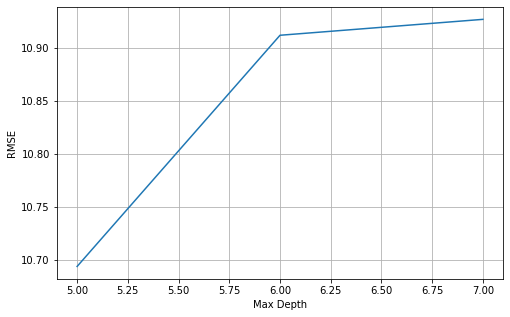

In [ ]:
# Plot result of max depth showing optimal depth.
# TODO: put a bold dot on the optimal depth point.
plt.figure(figsize = (8,5))
plt.plot(max_depth, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.grid()

In [ ]:
# Train model with optimal max depth
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
model_dt = DecisionTreeRegressor(max_depth=optimal_depth, random_state=0) 
model_dt.fit(X_train,y_train)
y_pred_dt = model_dt.predict(X_test)
rms_error = np.sqrt(mean_squared_error(y_test, y_pred_dt))

print(f"Optimal RMSE: {rms_error.round(2)}")

Optimal RMSE: 10.95


In [ ]:
# May need some feature column name cleanup
# TODO: There is one blank column name that needs dropping.
# data_clean_enc.columns.to_list()

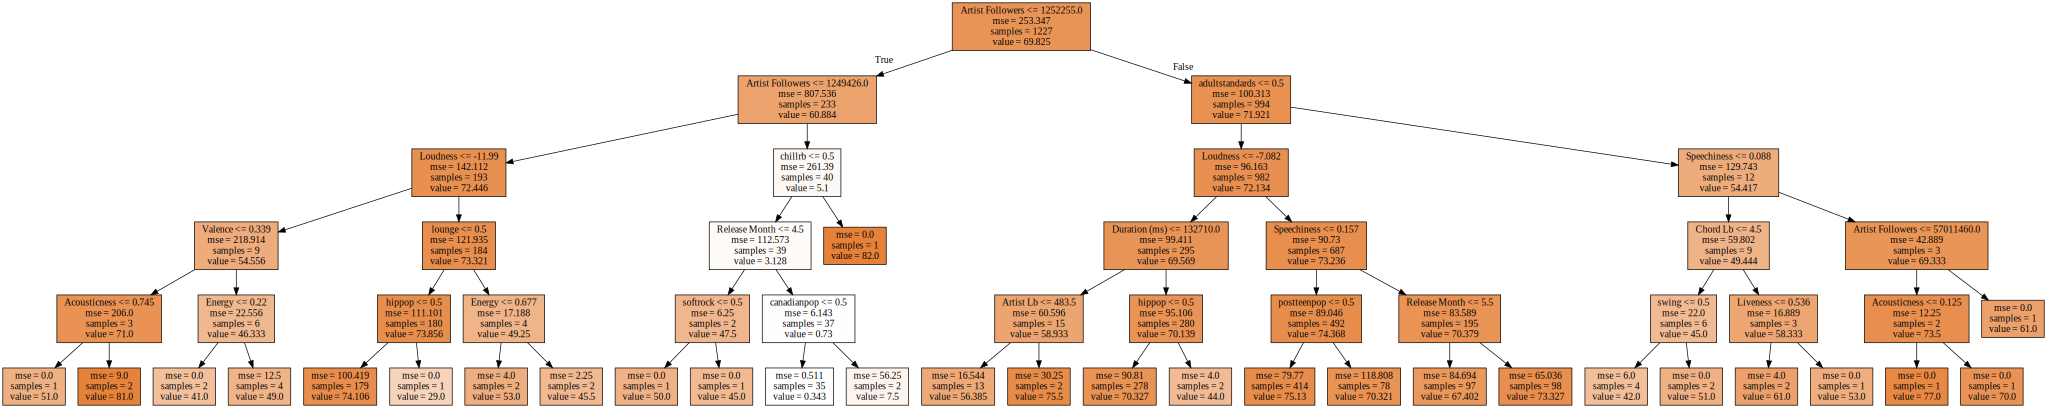

In [ ]:
# Option 1 
display(graphviz.Source(tree.export_graphviz(model_dt, feature_names=feature_names, filled = True)))

In [ ]:
# Visualize decision tree - not sure I want to as I have 351 predictors.
# plt.figure(figsize=(30,20))
# tree_plot = tree.plot_tree(model_dt, feature_names=feature_names, filled=True)

In [ ]:
# Visualize using dtreeviz
# dtreeviz(model, X_train, y_train, target_name=target_name, feature_names=feature_names)

# TODO: resolve error - TypeError: unsupported operand type(s) for -: 'str' and 'str'

## Random Forest

In [ ]:
# TODO change to higher value
# Number of iterations for cross validation
# Loop of 10 produces inconsistent results. 
# Anything over 50 produces optimal max depth between 5 and 7 - numbers are very close for all three.
num_loops = 50

# Try different number of trees - go from min to max in steps
# num_trees = range(min, max, steps)
num_trees = range(10, 60, 10)
rms_trees = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees):
  # Storage for each result so we can get mean from all iterations.
  rmse_results = np.zeros(num_loops)
  for idx in range(0,num_loops):
    # Create train and test data sets.
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
    # Configure model. Use optimal depth gained in Decision Tree above.
    model_rf = RandomForestRegressor(n_estimators=trees, max_depth=optimal_depth, random_state=0)
    model_rf.fit(X_train, y_train)
    y_pred_rf = model_rf.predict(X_test)
    rmse_results[idx] = np.sqrt(mean_squared_error(y_test, y_pred_rf))

  # Record RMSE by depth to find optimal depth
  rms_trees[n] = rmse_results.mean().round(3)

# Print result so we can see which tree count provided best RMSE
print(f"CV RMSE by Tree Count:\n")
for n, trees in enumerate(num_trees):
  print(f'Trees={num_trees[n]} | RMSE={rms_trees[n]}')
  if rms_trees[n] == rms_trees.min():
    optimal_trees = num_trees[n]
    print(f'Optimal Trees={optimal_trees}')

CV RMSE by Tree Count:

Trees=10 | RMSE=10.324
Trees=20 | RMSE=10.095
Optimal Trees=20
Trees=30 | RMSE=10.095
Optimal Trees=30
Trees=40 | RMSE=10.339
Trees=50 | RMSE=10.128


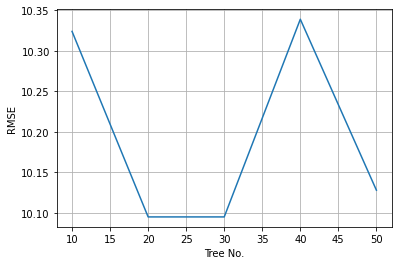

In [ ]:
# Visualize result of optimal number of trees.
plt.plot(num_trees, rms_trees)
plt.xlabel('Tree No.')
plt.ylabel('RMSE')
plt.grid()

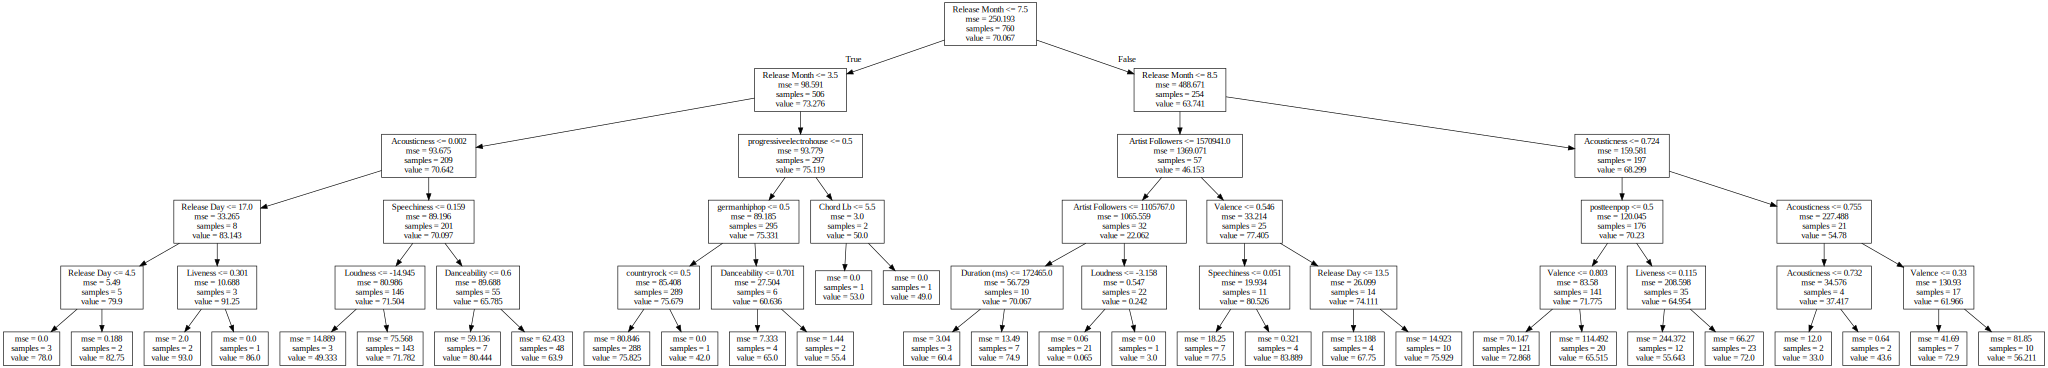

In [ ]:
# Display one tree from the random forest
display(graphviz.Source(tree.export_graphviz(model_rf.estimators_[0], feature_names=feature_names)))

## XG Boost

### CV With No Parameters

In [ ]:
# XG Boost - returns mse, not rmse. So need to take sqrt of result at end.
num_loops = 100
rmse_xgb  = np.zeros(num_loops)

for idx in range(0,num_loops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  model_xgb.fit(X_train,y_train)
  y_pred_xgb = model_xgb.predict(X_test)
  rmse_xgb[idx] = np.sqrt(mean_squared_error(y_test,y_pred_xgb))

print(f'CV RMSE XG Boost: {rmse_xgb.mean()}')

CV RMSE XG Boost: 10.039502826546075


Text(0, 0.5, 'Feature Importance Score')

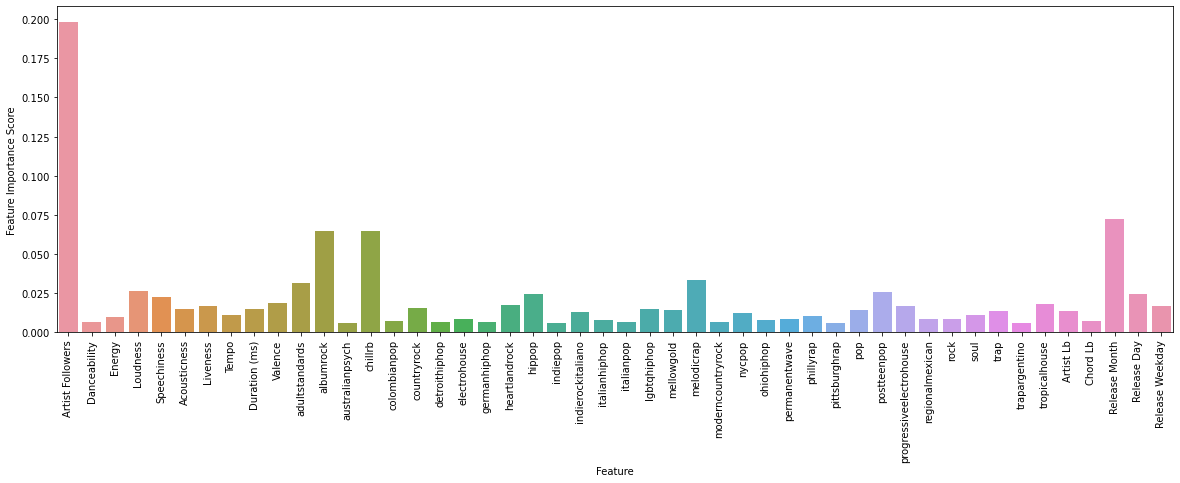

In [ ]:
# View feature importance score so we know which features are contributing to the outcome
feat_imp = pd.Series(model_xgb.feature_importances_, index=X.columns)

# get rid of NaN and zero feature importance
feat_imp.dropna(inplace=True)
feat_imp.drop(feat_imp[feat_imp.values == 0].index, inplace=True)

plt.figure(figsize = (20,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')

### CV With Optimized Parameters

In [ ]:
# Specify the parameters you want to try and their ranges. 
# small learning rate may require more estimators...
# max_depth = tree depth
# learning_rate = 
# n_estimators = number of trees
%time
param_test = {
 'max_depth':[5,6,7],
 'learning_rate' : [0.1, 0.2, 0.3, 0.4], 
 'n_estimators': [40,60,80,100],
}

# Perform the grid search
# Allows us to specify multiple parameters for CV from parameter dictionaries.
gsearch = GridSearchCV(estimator = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 10), 
                        param_grid = param_test, scoring='neg_mean_squared_error', cv=5)

# Fit to training data 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05)
model_xgb_grid = gsearch.fit(X_train,y_train)

# See grid search results
# TODO: Pull results into variables and then pass into the next CV.
print(model_xgb_grid.best_params_)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


In [ ]:
# View feature importance score so we know which features are contributing to the outcome
feat_imp = pd.Series(model_xgb_grid.feature_importances_, index=X.columns)

# get rid of NaN and zero feature importance
feat_imp.dropna(inplace=True)
feat_imp.drop(feat_imp[feat_imp.values == 0].index, inplace=True)

plt.figure(figsize = (20,6))
ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score')

# Communicate Results